# Рекомендательная система с использованием Machine Learning: Подключение к базе данных, EDA, feature engineering, обучение модели.

**Что требуется:**

- Научиться работать с большими таблицами из базы данных PostgreSQL (использовать pd.read_sql, batch загрузку через chunksize).
- Провести фичеинженерию: посчитать признаки для пользовательских взаимодействий с контентом.
- Сохранить рассчитанные признаки (feature table) обратно в базу данных (через .to_sql).
- Реализовать функцию batch_load_sql для загрузки признаков из БД по частям (чтобы не выходить за лимиты памяти).
- Обучить модель (например, CatBoost, LightGBM или sklearn), сохранить ее веса.
- Реализовать функцию загрузки модели (с использованием get_model_path).
- Для метрики HitRate@5: понимать, что она бинарная, и обучать модель на прокси-метрику (например, вероятность лайка).
- Установлены ограничения на качество модели: HitRate@5 должен быть больше 0,52.

### Для начала подключимся к базе данных PostgreSQL и взглянем на таблицы

In [ ]:
import sys
sys.path.append('../common')
from db_connect import get_engine

engine = get_engine()

# Данные по пользователям

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    con=engine
)

user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [ ]:
# Посты и топики

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    con=engine
)

posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [ ]:
# Данные о новостной ленте

count_feed_data = pd.read_sql(
    """SELECT count(*) FROM public.feed_data""",
    con=engine
)

count_feed_data.head()

,count
0,76892800


In [ ]:
# Почти 77 миллионов строк данных это много для оперативной памяти. 
# Попробуем выгрузить 10 млн. записей для дальнейшего обучения модели

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 10000000""",
    con=engine
)

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-19 17:53:58,118235,2103,view,0
1,2021-10-19 17:54:45,118235,3110,view,0
2,2021-10-19 17:55:23,118235,1487,view,0
3,2021-10-19 17:56:58,118235,1657,view,0
4,2021-10-19 17:58:24,118235,1016,view,0


### EDA и работа с признаками для контентной модели

In [ ]:
# Как устроена колонка target?

feed_data[feed_data.action!='view']

,timestamp,user_id,post_id,action,target
22,2021-11-02 11:13:33,118235,1933,like,0
28,2021-11-02 11:24:14,118235,381,like,0
32,2021-11-02 11:29:42,118235,6807,like,0
37,2021-11-08 20:06:23,124125,3694,like,0
54,2021-11-08 20:36:14,124125,36,like,0
...,...,...,...,...,...
9999978,2021-12-15 17:49:22,158889,500,like,0
9999984,2021-12-15 17:56:11,158889,1073,like,0
9999990,2021-12-29 20:17:54,158889,4815,like,0
9999997,2021-12-29 20:25:50,158889,4196,like,0


In [9]:
### Почистим данные от action != view

feed_data = feed_data[feed_data.action=='view']

feed_data.head()

,timestamp,user_id,post_id,action,target
0,2021-10-19 17:53:58,118235,2103,view,0
1,2021-10-19 17:54:45,118235,3110,view,0
2,2021-10-19 17:55:23,118235,1487,view,0
3,2021-10-19 17:56:58,118235,1657,view,0
4,2021-10-19 17:58:24,118235,1016,view,0


Можно было бы построить рекомендательную систему через коллаборативную фильтрацию, но данных слишком много и это будет занимать больше времени, если вообще
получится. 
Поэтому построим модель на базе элегантного контентного подхода - алгоритм, который берет вектор фичей по юзеру, вектор фичей по посту и 
смотря на признаки, дает прогноз о том, какой action будет совершен. 

Таким образом:
1. Выделим фичи для каждого юзера и для каждого поста. 
2. Далее получим некоторый train, в котором будут стоять 0 и 1 в колонке target, а также некие наборы фичей для каждого юзера и каждого поста. 
3. Поверх данной таблицы можно обучить модель, которая будет хорошо устанавливать взаимосвязь между пользователем и постом и давать результат - произойдет лайк или не произойдет. Если действительно юзер лайкнет посты из 5 постов, которые будут рекомендованы, значит рекомендательная система работающая. 

Возьмем юзера, возьмем момент времени, в который хотим порекомендовать ему фильм, пробежимся по всем постам, каждый из них в закинем модель вместе с выбранным юзером. Тогда получим для каждого из имеющихся постов вероятность того, что выбранный пользователь их лайнет. А для рекомендации произведем отсортированный отбор топ-5 кандидатов по выходам с наибольшего к наименьшему.

В чем объективный минус контентного подхода? Каждый раз, когда мы хотим дать рекомендацию, нам нужно засовывать в нашу модель все возможные посты, но когда их очень много - это большая проблема - информация должно быть много. В нашем случае постов всего 7000, поэтому контентный подход подходит. 

Обучимся по выбранной дате timestamp. Для любой пары (user_id, post_id) предсказывать, случится лайк или нет.

In [ ]:
# В целом, по таблице юзеров подойдет оригинальный датасет признаков

user_info

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [ ]:
### C post_id куда интереснее! Колонка text в данный момент дает нам мало информации в текстовом виде

posts_info

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [ ]:
# Приведем текст к единому виду для дальнейшего анализа, чтобы модель могла с ним работать
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

# Создаем экземпляр лемматизатора для приведения слов к нормальной форме
wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line

# Инициализация TF-IDF векторизатора с кастомным препроцессингом и стоп-словами
tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

Для работы с NLTK необходимо скачать ресурсы, например: nltk.download('wordnet')

In [ ]:
# Создадим матрицу признаков с помощью TF-IDF векторизации

tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data

/Users/anastasiasharina/Documents/ML_Engineer_karpov/Lessons/Module_3_Deep_Learning/final_project/final_project_env/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13273932, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05061394, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# Преобразуем массив TfIdf в датафрейм: строки — посты, столбцы — слова (признаки)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.050614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Создаем фичи на основе TfIdf

posts_info['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000275
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


In [ ]:
# Формируем список названий признаков расстояний до каждого из 15 кластеров

[f"DistanceTo{ith}thCluster" for ith in range(1, 16)]

['DistanceTo1thCluster',
 'DistanceTo2thCluster',
 'DistanceTo3thCluster',
 'DistanceTo4thCluster',
 'DistanceTo5thCluster',
 'DistanceTo6thCluster',
 'DistanceTo7thCluster',
 'DistanceTo8thCluster',
 'DistanceTo9thCluster',
 'DistanceTo10thCluster',
 'DistanceTo11thCluster',
 'DistanceTo12thCluster',
 'DistanceTo13thCluster',
 'DistanceTo14thCluster',
 'DistanceTo15thCluster']

In [ ]:
# Кластеризуем тексты

from sklearn.decomposition import PCA

# Центрируем матрицу TfIdf, чтобы признаки имели среднее значение 0
centered = tfidf_data - tfidf_data.mean()

# Снижаем размерность признаков с помощью PCA до 20 компонент
pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

from sklearn.cluster import KMeans

# Кластеризуем тексты с помощью KMeans на 15 кластеров
kmeans = KMeans(n_clusters=15, random_state=0).fit(pca_decomp)

# Добавляем номер текстового кластера в posts_info для каждого поста
posts_info['TextCluster'] = kmeans.labels_

# Формируем названия признаков расстояний до каждого из 15 кластеров
dists_columns = [
    'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
    'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
    'DistanceTo7thCluster', 'DistanceTo8thCluster', 'DistanceTo9thCluster',
    'DistanceTo10thCluster', 'DistanceTo11thCluster', 'DistanceTo12thCluster',
    'DistanceTo13thCluster', 'DistanceTo14thCluster', 'DistanceTo15thCluster'
]

# Создаем датафрейм с расстояниями до центров кластеров для каждого поста
dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

# Просматриваем первые строки таблицы с расстояниями
dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.499301,0.441953,0.444769,0.581023,0.153265,0.479889,0.502786,0.439978,0.430141,0.516707,0.534498,0.394667,0.546040,0.530801,0.466741
1,0.372566,0.295072,0.301726,0.344516,0.257868,0.343987,0.377716,0.297517,0.160542,0.397494,0.427264,0.201044,0.447750,0.417792,0.331029
2,0.394720,0.316258,0.331603,0.538713,0.132783,0.363097,0.390168,0.316629,0.330387,0.427999,0.447229,0.230198,0.479463,0.437719,0.356870
3,0.323662,0.266157,0.296932,0.498330,0.226690,0.323059,0.354368,0.262589,0.260343,0.395723,0.412433,0.149006,0.443402,0.390007,0.300517
4,0.294757,0.179256,0.228558,0.462365,0.285652,0.260498,0.296435,0.162436,0.213009,0.358068,0.401156,0.080493,0.399299,0.347068,0.234249


In [ ]:
# Добавим признаки расстояний до кластеров к posts_info

posts_info = pd.concat((posts_info,dists_df), axis=1)

posts_info.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,4,0.499301,0.441953,0.444769,...,0.479889,0.502786,0.439978,0.430141,0.516707,0.534498,0.394667,0.546040,0.530801,0.466741
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,8,0.372566,0.295072,0.301726,...,0.343987,0.377716,0.297517,0.160542,0.397494,0.427264,0.201044,0.447750,0.417792,0.331029
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000275,4,0.394720,0.316258,0.331603,...,0.363097,0.390168,0.316629,0.330387,0.427999,0.447229,0.230198,0.479463,0.437719,0.356870
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,11,0.323662,0.266157,0.296932,...,0.323059,0.354368,0.262589,0.260343,0.395723,0.412433,0.149006,0.443402,0.390007,0.300517
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,11,0.294757,0.179256,0.228558,...,0.260498,0.296435,0.162436,0.213009,0.358068,0.401156,0.080493,0.399299,0.347068,0.234249


In [21]:
### Воспроизведем датафрейм со всеми новыми фичами 

df = pd.merge(feed_data,
              posts_info,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,2021-10-19 17:53:58,118235,2103,view,0,Microsoft seeking spyware trojan\n\nMicrosoft ...,tech,6.561023,0.432187,0.000143,...,0.610193,0.625674,0.581955,0.590040,0.647434,0.668283,0.510471,0.680866,0.657349,0.603201
1,2021-10-19 17:54:45,118235,3110,view,0,.portland riot park had no covid rules. Rules ...,covid,3.111524,0.389931,0.000068,...,0.310557,0.337086,0.156476,0.297592,0.425822,0.446995,0.253864,0.439012,0.147110,0.221072
2,2021-10-19 17:55:23,118235,1487,view,0,What now for British tennis?\n\nTim Henmans de...,sport,10.204930,0.373058,0.000222,...,0.322603,0.351944,0.299452,0.281334,0.405488,0.451245,0.246115,0.399481,0.421896,0.331900
3,2021-10-19 17:56:58,118235,1657,view,0,Benitez delight after crucial win\n\nLiverpool...,sport,8.550321,0.497224,0.000186,...,0.367634,0.376085,0.364238,0.360619,0.361392,0.507203,0.335459,0.468197,0.473247,0.388218
4,2021-10-19 17:58:24,118235,1016,view,0,Straw praises Kashmir moves\n\nThe UK has welc...,politics,9.102057,0.316566,0.000198,...,0.285486,0.321045,0.229382,0.126033,0.400213,0.394877,0.152219,0.411791,0.368539,0.267517


In [ ]:
# Объединяем основной датафрейм с данными о пользователях по user_id.

df = pd.merge(df,
              user_info,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source
0,2021-10-19 17:53:58,118235,2103,view,0,Microsoft seeking spyware trojan\n\nMicrosoft ...,tech,6.561023,0.432187,0.000143,...,0.680866,0.657349,0.603201,0,32,Russia,Kurgan,3,Android,organic
1,2021-10-19 17:54:45,118235,3110,view,0,.portland riot park had no covid rules. Rules ...,covid,3.111524,0.389931,0.000068,...,0.439012,0.147110,0.221072,0,32,Russia,Kurgan,3,Android,organic
2,2021-10-19 17:55:23,118235,1487,view,0,What now for British tennis?\n\nTim Henmans de...,sport,10.204930,0.373058,0.000222,...,0.399481,0.421896,0.331900,0,32,Russia,Kurgan,3,Android,organic
3,2021-10-19 17:56:58,118235,1657,view,0,Benitez delight after crucial win\n\nLiverpool...,sport,8.550321,0.497224,0.000186,...,0.468197,0.473247,0.388218,0,32,Russia,Kurgan,3,Android,organic
4,2021-10-19 17:58:24,118235,1016,view,0,Straw praises Kashmir moves\n\nThe UK has welc...,politics,9.102057,0.316566,0.000198,...,0.411791,0.368539,0.267517,0,32,Russia,Kurgan,3,Android,organic


In [ ]:
# Также выделим признак из timestamp, поскольку от времени просмотра может зависеть склонность пользователей лайкать или игнорировать посты

df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

df.head()

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,...,DistanceTo15thCluster,gender,age,country,city,exp_group,os,source,hour,month
0,2021-10-19 17:53:58,118235,2103,view,0,Microsoft seeking spyware trojan\n\nMicrosoft ...,tech,6.561023,0.432187,0.000143,...,0.603201,0,32,Russia,Kurgan,3,Android,organic,17,10
1,2021-10-19 17:54:45,118235,3110,view,0,.portland riot park had no covid rules. Rules ...,covid,3.111524,0.389931,0.000068,...,0.221072,0,32,Russia,Kurgan,3,Android,organic,17,10
2,2021-10-19 17:55:23,118235,1487,view,0,What now for British tennis?\n\nTim Henmans de...,sport,10.204930,0.373058,0.000222,...,0.331900,0,32,Russia,Kurgan,3,Android,organic,17,10
3,2021-10-19 17:56:58,118235,1657,view,0,Benitez delight after crucial win\n\nLiverpool...,sport,8.550321,0.497224,0.000186,...,0.388218,0,32,Russia,Kurgan,3,Android,organic,17,10
4,2021-10-19 17:58:24,118235,1016,view,0,Straw praises Kashmir moves\n\nThe UK has welc...,politics,9.102057,0.316566,0.000198,...,0.267517,0,32,Russia,Kurgan,3,Android,organic,17,10


In [ ]:
# Уберем ненужные колонки

df = df.drop([
#    'timestamp',  # timestamp пока оставим
    'action',
    'text',
],
    axis=1)

df = df.set_index(['user_id', 'post_id'])

df.head(50)

timestamp  target          topic  TotalTfIdf  \
user_id post_id                                                          
118235  2103    2021-10-19 17:53:58       0           tech    6.561023   
        3110    2021-10-19 17:54:45       0          covid    3.111524   
        1487    2021-10-19 17:55:23       0          sport   10.204930   
        1657    2021-10-19 17:56:58       0          sport    8.550321   
        1016    2021-10-19 17:58:24       0       politics    9.102057   
        120     2021-10-19 18:00:02       0       business   10.415818   
        1906    2021-10-19 18:00:48       0          sport    6.871374   
        3210    2021-10-19 18:03:20       0          covid    2.914132   
        1679    2021-10-19 18:04:59       0          sport   12.885721   
        1421    2021-10-19 18:07:54       0          sport    7.153539   
        1607    2021-10-19 18:08:29       0          sport    8.426755   
        724     2021-10-19 18:09:03       0  entertainment    9.858247   
        993     2021-10-19 18:11:21       0       politics    9.099300   
        1627    2021-10-19 18:14:20       0          sport    8.183979   
        1173    2021-10-19 18:14:40       0       politics    6.612242   
        1629    2021-10-19 18:14:54       0          sport   10.781873   
        1458    2021-10-19 18:16:47       0          sport   14.629456   
        1683    2021-10-19 18:17:33       0          sport    9.740803   
        970     2021-10-19 18:18:06       0       politics    6.150186   
        3680    2021-11-02 11:09:41       0          covid    3.331948   
        808     2021-11-02 11:10:49       0  entertainment    8.869204   
        1933    2021-11-02 11:11:07       1           tech   10.351142   
        6062    2021-11-02 11:13:35       0          movie    7.235079   
        4433    2021-11-02 11:14:42       0          movie    6.739365   
        3620    2021-11-02 11:16:30       0          covid    3.059010   
        4982    2021-11-02 11:19:04       0          movie    5.835449   
        381     2021-11-02 11:21:47       1       business    8.250155   
        6258    2021-11-02 11:24:16       0          movie    7.541446   
        6762    2021-11-02 11:26:57       0          movie    6.467513   
        6807    2021-11-02 11:28:18       1          movie    5.062270   
        4869    2021-11-02 11:29:44       0          movie    8.033109   
        2795    2021-11-02 11:30:17       0          covid    2.798439   
        4964    2021-11-02 11:30:57       1          movie    6.179481   
124125  3694    2021-11-08 20:04:42       1          covid    3.248174   
        1069    2021-11-08 20:06:25       0       politics   11.351389   
        4449    2021-11-08 20:07:20       0          movie    7.929378   
        6266    2021-11-08 20:10:07       0          movie    6.155153   
        4248    2021-11-08 20:12:47       0          movie    8.728409   
        5823    2021-11-08 20:15:15       0          movie    7.621883   
        5286    2021-11-08 20:17:01       0          movie    9.957966   
        2876    2021-11-08 20:19:35       0          covid    3.539742   
        3741    2021-11-08 20:21:48       0          covid    2.886255   
        5088    2021-11-08 20:24:44       0          movie    9.956033   
        2924    2021-11-08 20:26:37       0          covid    2.910238   
        7012    2021-11-08 20:28:33       0          movie   11.889470   
        130     2021-11-08 20:28:51       0       business    8.217887   
        6844    2021-11-08 20:29:41       0          movie    6.898529   
        159     2021-11-08 20:30:58       0       business    7.788604   
        252     2021-11-08 20:33:20       0       business   10.485886   
        36      2021-11-08 20:35:39       1       business   11.270309   

                 MaxTfIdf  MeanTfIdf  TextCluster  DistanceTo1thCluster  \
user_id post_id                                                           
118235  2103     0.432187  

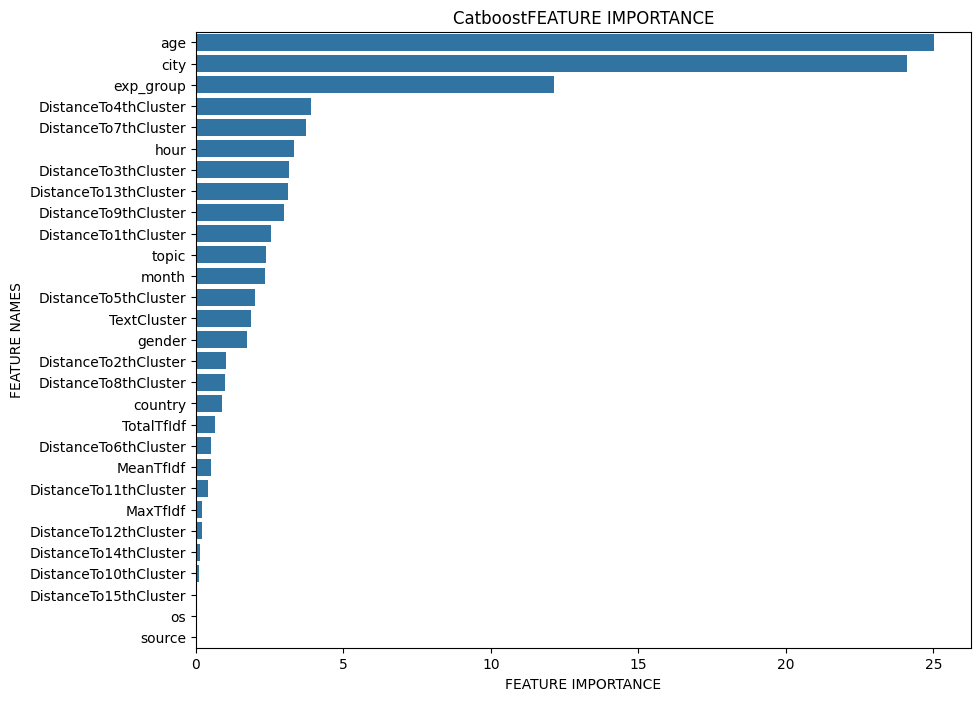

In [ ]:
# Посмотрим на feature_importance

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(importance, names, model_type):
    
    # Создаем массивы из важности признаков и их названий
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    # Создаем DataFrame с помощью словаря
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    
    # Сортируем DataFrame по убыванию важности признаков
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    # Определяем размер графика
    plt.figure(figsize=(10, 8))
    # Строим bar chart с помощью Seaborn
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Добавляем подписи к графику
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE IMPORTANCE')
    
plot_feature_importance(catboost.feature_importances_, X_train.columns, 'Catboost')

### Теперь обучим модели

Предлагаю начать с с решающего дерева.

Выборки train и test разобьем по времени, так как данные имеют временную структуру, к тому же мы хотим корректно оценивать вероятности для будущих рекомендаций.

In [ ]:
# Смотрим на максимальное и минимальное значение timestamp в датафрейме

max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:44:39'), Timestamp('2021-10-01 06:02:14'))

In [ ]:
# За отсечку возьмем 2021-12-15

df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((7430860,), (1504095,))

In [ ]:
# Итого наша тренировочная выборка выглядит так

X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
user_id post_id                                                           
118235  2103         tech    6.561023  0.432187   0.000143           11   
        3110        covid    3.111524  0.389931   0.000068           13   
        1487        sport   10.204930  0.373058   0.000222            2   
        1657        sport    8.550321  0.497224   0.000186            2   
        1016     politics    9.102057  0.316566   0.000198            8   
...                   ...         ...       ...        ...          ...   
36442   3293        covid    3.074909  0.465180   0.000067           14   
        6300        movie    5.891233  0.450808   0.000128            6   
        4024        covid    3.400981  0.380440   0.000074           13   
        4559        movie    5.579722  0.400295   0.000121            6   
        3759        covid    2.939896  0.410558   0.000064           14   

                 DistanceTo1thCluster  DistanceTo2thCluster  \
user_id post_id                                               
118235  2103                 0.631338              0.582314   
        3110                 0.302751              0.240052   
        1487                 0.395346              0.263133   
        1657                 0.453734              0.317715   
        1016                 0.306244              0.222566   
...                               ...                   ...   
36442   3293                 0.213385              0.236860   
        6300                 0.464822              0.323767   
        4024                 0.337238              0.328838   
        4559                 0.412606              0.249689   
        3759                 0.220191              0.225723   

                 DistanceTo3thCluster  DistanceTo4thCluster  \
user_id post_id                                               
118235  2103                 0.593802              0.716423   
        3110                 0.297706              0.511769   
        1487                 0.127543              0.490319   
        1657                 0.191230              0.539789   
        1016                 0.246487              0.419613   
...                               ...                   ...   
36442   3293                 0.287655              0.520602   
        6300                 0.408356              0.590995   
        4024                 0.372053              0.568434   
        4559                 0.354610              0.560834   
        3759                 0.281425              0.509789   

                 DistanceTo5thCluster  ...  DistanceTo15thCluster  gender  \
user_id post_id                        ...                                  
118235  2103                 0.638723  ...               0.603201       0   
        3110                 0.371996  ...               0.221072       0   
        1487                 0.345844  ...               0.331900       0   
        1657                 0.434264  ...               0.388218       0   
        1016                 0.282722  ...               0.267517       0   
...                               ...  ...                    ...     ...   
36442   3293                 0.371758  ...               0.054408       1   
        6300                 0.487985  ...               0.418500       1   
        4024                 0.437376  ...               0.318039       1   
        4559                 0.436919  ...               0.353485       1   
        3759                 0.360601  ...               0.032617       1   

                 age  country    city  exp_group       os   source  hour  \
user_id post_id                                                            
118235  2103      32   Russia  Kurgan          3  Android  organic    17   
        3110      32   Russia  Kurgan          3  Android  organic    17   
        1487      32   Russia  Kurgan          3  Android  organic    17   
        1657      32  

In [ ]:
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder

# Список категориальных признаков
object_cols = [
    'topic', 'TextCluster', 'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

# Выделяем признаки для OneHotEncoder (мало уникальных значений)
cols_for_ohe = [x for x in object_cols if X_train[x].nunique() < 5]
# Выделяем признаки для TargetEncoder (много уникальных значений)
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

# Сохраняем индексы колонок для энкодеров
cols_for_ohe_idx = [list(X_train.columns).index(col) for col in cols_for_ohe]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

# Формируем список трансформеров для категориальных признаков
t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_ohe_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx)
]

# Создаем объект для трансформации признаков
col_transform = ColumnTransformer(transformers=t)

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# Собираем пайплайн: сначала преобразуем признаки, затем обучаем дерево решений
pipe_dt = Pipeline([("column_transformer",
                     col_transform),
                    ("decision_tree", 
                     DecisionTreeClassifier())])

# Обучаем пайплайн на тренировочных данных
pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(),
                                                  [20, 28, 25, 26]),
                                                 ('MeanTargetEncoder',
                                                  TargetEncoder(),
                                                  [0, 4, 22, 23, 24, 27])])),
                ('decision_tree', DecisionTreeClassifier())])

In [ ]:
# Замерим качество работы такой модели - возьмем ROC-AUC. Модель сильно переобучилась и не умеет делать предсказания на новых данных

from sklearn.metrics import roc_auc_score

print(f"Качество на трейне: {roc_auc_score(y_train, pipe_dt.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, pipe_dt.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9031890104890654
Качество на тесте: 0.5369500625340449


In [ ]:
# Теперь обучим катбуст

from catboost import CatBoostClassifier

catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, object_cols)

0:	learn: 0.3554666	total: 2.35s	remaining: 3m 52s
1:	learn: 0.3484446	total: 4.82s	remaining: 3m 55s
2:	learn: 0.3472804	total: 6.67s	remaining: 3m 35s
3:	learn: 0.3465893	total: 8.51s	remaining: 3m 24s
4:	learn: 0.3464130	total: 10s	remaining: 3m 10s
5:	learn: 0.3459784	total: 11.6s	remaining: 3m 2s
6:	learn: 0.3458493	total: 13.3s	remaining: 2m 57s
7:	learn: 0.3457696	total: 15.1s	remaining: 2m 54s
8:	learn: 0.3457307	total: 16.6s	remaining: 2m 48s
9:	learn: 0.3453222	total: 18.2s	remaining: 2m 44s
10:	learn: 0.3452630	total: 19.9s	remaining: 2m 40s
11:	learn: 0.3446806	total: 21.5s	remaining: 2m 37s
12:	learn: 0.3446399	total: 23.7s	remaining: 2m 38s
13:	learn: 0.3443780	total: 25.3s	remaining: 2m 35s
14:	learn: 0.3443543	total: 26.8s	remaining: 2m 32s
15:	learn: 0.3440224	total: 28.3s	remaining: 2m 28s
16:	learn: 0.3436143	total: 30s	remaining: 2m 26s
17:	learn: 0.3435715	total: 31.7s	remaining: 2m 24s
18:	learn: 0.3434872	total: 33.2s	remaining: 2m 21s
19:	learn: 0.3430865	total:

In [ ]:
# Замерим качество работы такой модели - возьмем ROC-AUC. Модель CatBoost показывает стабильное, среднее качество. Она не переобучена, 
# хорошо работает на новых данных. Это хороший базовый результат для рекомендательной системы и подходит под условия требований.

print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6672817135661437
Качество на тесте: 0.649721774510919


In [33]:
### Сохраним модель

catboost.save_model(
    'model',
    format="cbm"                  
)

### Положим в базу фичи, необходимые для функционала нашей модели

In [ ]:
# Сохраним датафрейм с признаками постов в таблицу "anastasia_sharina_7" в базе данных

posts_info.to_sql(
    "anastasia_sharina_7",
    con=engine,
    schema="public",
    if_exists='replace'
)  

23

In [ ]:
# Загружаем таблицу "anastasia_sharina_7" из базы данных в датафрейм

import pandas as pd

df = pd.read_sql(
    "SELECT * FROM public.anastasia_sharina_7",
    con=engine
)
print(df.head())

   index  post_id                                               text  \
0      0        1  UK economy facing major risks\n\nThe UK manufa...   
1      1        2  Aids and climate top Davos agenda\n\nClimate c...   
2      2        3  Asian quake hits European shares\n\nShares in ...   
3      3        4  India power shares jump on debut\n\nShares in ...   
4      4        5  Lacroix label bought by US firm\n\nLuxury good...   

      topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  TextCluster  \
0  business    8.748129  0.495805   0.000190            4   
1  business   11.878472  0.308003   0.000258            8   
2  business   12.675530  0.261799   0.000275            4   
3  business    6.622786  0.537713   0.000144           11   
4  business    6.352096  0.420251   0.000138           11   

   DistanceTo1thCluster  DistanceTo2thCluster  ...  DistanceTo6thCluster  \
0              0.499301              0.441953  ...              0.479889   
1              0.372566              0.295072  .

In [ ]:
# Тестируем. Выглядит отлично!

test_ = pd.read_sql(
    """SELECT * FROM public.anastasia_sharina_7""",
    con=engine
)

test_

,index,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,4,0.499301,0.441953,...,0.479889,0.502786,0.439978,0.430141,0.516707,0.534498,0.394667,0.546040,0.530801,0.466741
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,8,0.372566,0.295072,...,0.343987,0.377716,0.297517,0.160542,0.397494,0.427264,0.201044,0.447750,0.417792,0.331029
2,2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000275,4,0.394720,0.316258,...,0.363097,0.390168,0.316629,0.330387,0.427999,0.447229,0.230198,0.479463,0.437719,0.356870
3,3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,11,0.323662,0.266157,...,0.323059,0.354368,0.262589,0.260343,0.395723,0.412433,0.149006,0.443402,0.390007,0.300517
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,11,0.294757,0.179256,...,0.260498,0.296435,0.162436,0.213009,0.358068,0.401156,0.080493,0.399299,0.347068,0.234249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie,10.326422,0.300231,0.000224,6,0.539594,0.387775,...,0.415562,0.259924,0.473781,0.485362,0.557897,0.593867,0.466609,0.576553,0.565707,0.500662
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703322,0.258411,0.000146,6,0.429308,0.246225,...,0.313614,0.128784,0.343823,0.374009,0.464505,0.503544,0.346865,0.491440,0.450740,0.374676
7020,7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.573061,0.000122,5,0.344058,0.162597,...,0.063146,0.274628,0.234161,0.306111,0.406865,0.451500,0.254480,0.398660,0.380536,0.278383
7021,7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.231244,0.000150,5,0.380257,0.190028,...,0.168341,0.279091,0.285045,0.317505,0.413378,0.465962,0.275040,0.363761,0.415177,0.323342
